rawdata-> cocoa required files
rawdata-> firecrow required files


cocoa file list:
    data_file = des_y1_obs.datavector
    cov_file = des_y1_obs_cov
    mask_file = des_y1_obs.mask
    nz_lens_file = des_y1_lens.nz
    nz_source_file = des_y1_srcs.nz
    lens_ntomo = 5
    source_ntomo = 4
    n_theta = 20
    theta_min_arcmin = 2.5
    theta_max_arcmin = 250.

firecrown file included in sacc_data.fits:
    nz_lens
    nz_source
    xip
    xim
    gammat
    wtheta
    covmat


So next I need to do the following:
1. look into generate_des_data.py and get a picture what the transferred firecrown data look like?
2. develop pipline transfer real data into formats cocoa required while aligning the process from firecrown data
3. first run cocoa evaluation (some fiducial value) and all parameters and then use these for firecrown evaluation (maybe run a mcmc to get fiducial parameters?)
4. develop plot pipeline to plot and compare firecrown and cocoa datavectors
    

### follow the generate_des_data.py and see what happened

In [1]:
angles = """\
## angle_range_xip_1_1 = 7.195005 250.0
## angle_range_xip_1_2 = 7.195005 250.0
## angle_range_xip_1_3 = 5.715196 250.0
## angle_range_xip_1_4 = 5.715196 250.0
## angle_range_xip_2_1 = 7.195005 250.0
## angle_range_xip_2_2 = 4.539741 250.0
## angle_range_xip_2_3 = 4.539741 250.0
## angle_range_xip_2_4 = 4.539741 250.0
## angle_range_xip_3_1 = 5.715196 250.0
## angle_range_xip_3_2 = 4.539741 250.0
## angle_range_xip_3_3 = 3.606045 250.0
## angle_range_xip_3_4 = 3.606045 250.0
## angle_range_xip_4_1 = 5.715196 250.0
## angle_range_xip_4_2 = 4.539741 250.0
## angle_range_xip_4_3 = 3.606045 250.0
## angle_range_xip_4_4 = 3.606045 250.0
## angle_range_xim_1_1 = 90.579750 250.0
## angle_range_xim_1_2 = 71.950053 250.0
## angle_range_xim_1_3 = 71.950053 250.0
## angle_range_xim_1_4 = 71.950053 250.0
## angle_range_xim_2_1 = 71.950053 250.0
## angle_range_xim_2_2 = 57.151958 250.0
## angle_range_xim_2_3 = 57.151958 250.0
## angle_range_xim_2_4 = 45.397414 250.0
## angle_range_xim_3_1 = 71.950053 250.0
## angle_range_xim_3_2 = 57.151958 250.0
## angle_range_xim_3_3 = 45.397414 250.0
## angle_range_xim_3_4 = 45.397414 250.0
## angle_range_xim_4_1 = 71.950053 250.0
## angle_range_xim_4_2 = 45.397414 250.0
## angle_range_xim_4_3 = 45.397414 250.0
## angle_range_xim_4_4 = 36.060448 250.0
## angle_range_gammat_1_1 = 64.0 250.0
## angle_range_gammat_1_2 = 64.0 250.0
## angle_range_gammat_1_3 = 64.0 250.0
## angle_range_gammat_1_4 = 64.0 250.0
## angle_range_gammat_2_1 = 40.0 250.0
## angle_range_gammat_2_2 = 40.0 250.0
## angle_range_gammat_2_3 = 40.0 250.0
## angle_range_gammat_2_4 = 40.0 250.0
## angle_range_gammat_3_1 = 30.0 250.0
## angle_range_gammat_3_2 = 30.0 250.0
## angle_range_gammat_3_3 = 30.0 250.0
## angle_range_gammat_3_4 = 30.0 250.0
## angle_range_gammat_4_1 = 24.0 250.0
## angle_range_gammat_4_2 = 24.0 250.0
## angle_range_gammat_4_3 = 24.0 250.0
## angle_range_gammat_4_4 = 24.0 250.0
## angle_range_gammat_5_1 = 21.0 250.0
## angle_range_gammat_5_2 = 21.0 250.0
## angle_range_gammat_5_3 = 21.0 250.0
## angle_range_gammat_5_4 = 21.0 250.0
## angle_range_wtheta_1_1 = 43.0 250.0
## angle_range_wtheta_2_2 = 27.0 250.0
## angle_range_wtheta_3_3 = 20.0 250.0
## angle_range_wtheta_4_4 = 16.0 250.0
## angle_range_wtheta_5_5 = 14.0 250.0"""

In [2]:
import fitsio
import numpy as np
import sacc
import matplotlib.pyplot as plt

In [3]:
# Type specifications for the bin information.
Bin = tuple[float, float]
BinIndex = tuple[int, int]

In [4]:
#this file read the angle limits of datavector
#which in cocoa are included in just one file '.mask'

bin_limits: dict[str, dict[BinIndex, Bin]] = {}
for line in angles.split("\n"):
    items = line.split()
    keys = items[1].replace("angle_range_", "").split("_")
    topkey = keys[0]
    binkeys = (int(keys[1]), int(keys[2]))
    if topkey not in bin_limits:
        bin_limits[topkey] = {}
    bin_limits[topkey][binkeys] = (2.5, 250.0)#(float(items[-2]), float(items[-1]))

In [5]:
n_srcs = 4
n_lens = 5

# this holds a global mask of which elements of the data vector to keep
tot_msk = []

sacc_data = sacc.Sacc()

In [6]:
data = fitsio.FITS("2pt_NG_mcal_1110.fits")

dndz = data["nz_lens"].read()
for i in range(1, n_lens + 1):
    sacc_data.add_tracer("NZ", f"lens{i - 1}", dndz["Z_MID"], dndz[f"BIN{i}"])

# nz_src
dndz = data["nz_source"].read()
for i in range(1, n_srcs + 1):
    sacc_data.add_tracer("NZ", f"src{i - 1}", dndz["Z_MID"], dndz[f"BIN{i}"])

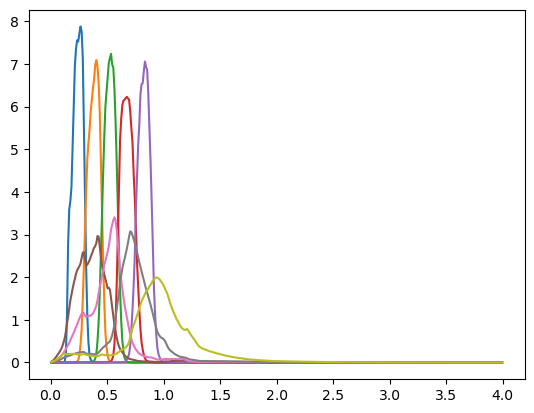

In [7]:
dndz = data["nz_lens"].read()
for i in range(1,n_lens+1):
    plt.plot(dndz["Z_MID"], dndz[f'BIN{i}'])

dndz = data["nz_source"].read()
for i in range(1,n_srcs+1):
    plt.plot(dndz["Z_MID"], dndz[f'BIN{i}'])


In [8]:
# this block select data by tomograpy combinations
# then select the data by angle scale

# xip
xip = data["xip"].read()
for i in range(1, n_srcs + 1):
    for j in range(i, n_srcs + 1):
        theta_min, theta_max = bin_limits["xip"][(i, j)]

        ij_msk = (xip["BIN1"] == i) & (xip["BIN2"] == j)
        xip_ij = xip[ij_msk]
        msk = (xip_ij["ANG"] > theta_min) & (xip_ij["ANG"] < theta_max)

        tot_msk.extend(msk.tolist())

        sacc_data.add_theta_xi(
            "galaxy_shear_xi_plus",
            f"src{i - 1}",
            f"src{j - 1}",
            xip_ij["ANG"][msk],
            xip_ij["VALUE"][msk],
        )

In [9]:
# xim
xim = data["xim"].read()
for i in range(1, n_srcs + 1):
    for j in range(i, n_srcs + 1):
        theta_min, theta_max = bin_limits["xim"][(i, j)]

        ij_msk = (xim["BIN1"] == i) & (xim["BIN2"] == j)
        xim_ij = xim[ij_msk]
        msk = (xim_ij["ANG"] > theta_min) & (xim_ij["ANG"] < theta_max)

        tot_msk.extend(msk.tolist())

        sacc_data.add_theta_xi(
            "galaxy_shear_xi_minus",
            f"src{i - 1}",
            f"src{j - 1}",
            xim_ij["ANG"][msk],
            xim_ij["VALUE"][msk],
        )

In [10]:
# gammat
gammat = data["gammat"].read()
for i in range(1, n_lens + 1):
    for j in range(1, n_srcs + 1):
        theta_min, theta_max = bin_limits["gammat"][(i, j)]

        ij_msk = (gammat["BIN1"] == i) & (gammat["BIN2"] == j)
        gammat_ij = gammat[ij_msk]
        msk = (gammat_ij["ANG"] > theta_min) & (gammat_ij["ANG"] < theta_max)

        tot_msk.extend(msk.tolist())

        sacc_data.add_theta_xi(
            "galaxy_shearDensity_xi_t",
            f"lens{i - 1}",
            f"src{j - 1}",
            gammat_ij["ANG"][msk],
            gammat_ij["VALUE"][msk],
        )

In [11]:
# wtheta
wtheta = data["wtheta"].read()
for i in range(1, n_lens + 1):
    theta_min, theta_max = bin_limits["wtheta"][(i, i)]

    ii_msk = (wtheta["BIN1"] == i) & (wtheta["BIN2"] == i)
    wtheta_ii = wtheta[ii_msk]
    msk = (wtheta_ii["ANG"] > theta_min) & (wtheta_ii["ANG"] < theta_max)

    tot_msk.extend(msk.tolist())

    sacc_data.add_theta_xi(
        "galaxy_density_xi",
        f"lens{i - 1}",
        f"lens{i - 1}",
        wtheta_ii["ANG"][msk],
        wtheta_ii["VALUE"][msk],
    )

In [12]:
#this block read original cov and construct new cov in a very clever way

msk_inds = np.where(tot_msk)[0]
n_cov = np.sum(tot_msk)
old_cov = data["COVMAT"].read()
new_cov = np.zeros((np.sum(tot_msk), np.sum(tot_msk)))

for new_cov_i, old_cov_i in enumerate(msk_inds):
    for new_cov_j, old_cov_j in enumerate(msk_inds):
        new_cov[new_cov_i, new_cov_j] = old_cov[old_cov_i, old_cov_j]

### Now study how to convert to cocoa file we need

data_file = lsst_y1_theory.modelvector
    :keep all data vectors record
cov_file = lsst_y1_cov
    :keep all and pay attention to the format!!!
mask_file = lsst_y1_M1_GGLOLAP0.05.mask
    :tot_msk should work
nz_lens_file = lsst_y1_lens.nz 
    :z, n1, n2, n3, n4, n5
nz_source_file = lsst_y1_source.nz
    :z, n1, n2, n3, n4, n5
lens_ntomo = 5 -> 5
source_ntomo = 5 -> 4
n_theta = 26 —> 20
theta_min_arcmin = 2.5 -> 2.5
theta_max_arcmin = 900. -> 250
baryon_pca_file = pca.txt -> no such file

### Now save the datavectors for y1 data

In [13]:
# xip (4+6)*20 = 200
# xim (4+6)*20 = 200
# gammat (4*5)*20 = 400
# w(theta) 5*20 = 100

datavectors = np.hstack((xip['VALUE'],xim['VALUE'],gammat['VALUE'],wtheta['VALUE']))
with open('./files4cocoa/des_y1_obs.datavector','w',encoding='utf-8') as f:
    for i, val in enumerate(datavectors):
        line = f"{i} {val:.8e}\n"
        f.write(line)

### Now save cov file for y1 data

In [14]:
# x_idx, y_indx, angle1_rad, angle2_rad, tomo1, tomo2, tomo3, tomo4, C_Gau, C_nonGau
# i don't fully follow the cov writing order. it should be fine as long as I do the index right?
N = len(datavectors)

xip_tomos = [(i,j) for i in range(4) for j in range(i,4) for k in range(20)]
xim_tomos = [(i,j) for i in range(4) for j in range(i,4) for k in range(20)]
gammat_tomos = [(i,j) for i in range(5) for j in range(4) for k in range(20)]
wtheta_tomos = [(i,i) for i in range(5) for k in range(20)]

tomos = xip_tomos+xim_tomos+gammat_tomos+wtheta_tomos
angles = np.tile(xip['ANG'][:20]/180*(np.pi/60), (10+10+20+5))

with open('./files4cocoa/des_y1_obs_cov','w', encoding='utf-8') as f:
    for i in range(N):
        for j in range(N):
            #line = f"{i} {j} {angles[i]:.6e} {angles[j]:.6e} {tomos[i][0]} {tomos[i][1]} {tomos[j][0]} {tomos[j][1]} {old_cov[i,j]:.6e} {0:.6e}\n"
            line = f"{i} {j} {old_cov[i,j]:.6e}\n"
            f.write(line)


### validate the cov

In [3]:
#cov_save = np.loadtxt('./files4cocoa/des_y1_obs_cov')

#cov = np.zeros((N,N))
#rows = cov_save[:,0].astype(int)
#columns = cov_save[:,1].astype(int)
#cov[rows,columns] = cov_save[:,8]
#plt.imshow(np.log(cov))
#check the image of every column of the cov and it makes sense

### now build the mask file

In [15]:
with open('files4cocoa/des_y1_obs.mask','w',encoding='utf-8') as f:
    for i in range(N):
        if tot_msk[i] :
            line = f'{i} {1.0}\n'
        else:
            line = f'{i} {0.0}\n'
        f.write(line)

### now build the nz file

In [17]:
#lens: z n1 n2 n3 n4 n5
#srcs: z n1 n2 n3 n4
dndz = data["nz_lens"].read()
z = dndz['Z_MID']
with open('files4cocoa/des_y1_lens.nz','w',encoding='utf-8') as f:
    for i in range(len(z)):
        nz = np.array(dndz[i].tolist())[-5:]
        line = f'{z[i]:.18e} {nz[0]:.18e} {nz[1]:.18e} {nz[2]:.18e} {nz[3]:.18e} {nz[4]:.18e}\n'
        f.write(line)

dndz = data["nz_source"].read()
z = dndz['Z_MID']
with open('files4cocoa/des_y1_srcs.nz','w',encoding='utf-8') as f:
    for i in range(len(z)):
        nz = np.array(dndz[i].tolist())[-4:]
        line = f'{z[i]:.18e} {nz[0]:.18e} {nz[1]:.18e} {nz[2]:.18e} {nz[3]:.18e}\n'
        f.write(line)


### BINNING

In [16]:
angles = xip['ANG'][:20]
print(angles)

[  2.82892205   3.56145195   4.48383125   5.64515088   7.10700175
   8.94802743  11.26359312  14.18012136  17.85303226  22.47319161
  28.29405514  35.61746915  44.8381916   56.44731998  71.05929607
  89.45541049 112.61560585 141.76374877 178.46262927 224.64388959]


In [4]:
# 2/3* (max**2 + min**2 + max*min) / (max+min)

argmin = 2.5
argmax = 250.
bins_num = 20
thetas = 10.**(np.linspace(np.log10(argmin,dtype=np.float64),np.log10(argmax,dtype=np.float64),bins_num+1))
centers = (2/3) * ((thetas[1:]**2 + thetas[:-1]**2 + thetas[1:]*thetas[:-1]) / (thetas[1:]+thetas[:-1]))
print(centers)

[  2.83602296   3.57034138   4.49479349   5.65860974   7.1237676
   8.96829206  11.29041078  14.21378504  17.89409518  22.52733114
  28.36022963  35.70341377  44.94793488  56.58609743  71.23767601
  89.68292061 112.90410776 142.13785035 178.94095179 225.27331141]


### Build Unmasked Data for Firecrown

In [3]:
"""Generate the firecrown input from the DES Y1 3x2pt data products.

Before running this script, you must first download the DES Y1 3x2pt data
products from:
   http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

"""

import fitsio
import numpy as np
import sacc

# bin limits are from the chain headers courtesy of M. Troxel
angles = """\
## angle_range_xip_1_1 = 7.195005 250.0
## angle_range_xip_1_2 = 7.195005 250.0
## angle_range_xip_1_3 = 5.715196 250.0
## angle_range_xip_1_4 = 5.715196 250.0
## angle_range_xip_2_1 = 7.195005 250.0
## angle_range_xip_2_2 = 4.539741 250.0
## angle_range_xip_2_3 = 4.539741 250.0
## angle_range_xip_2_4 = 4.539741 250.0
## angle_range_xip_3_1 = 5.715196 250.0
## angle_range_xip_3_2 = 4.539741 250.0
## angle_range_xip_3_3 = 3.606045 250.0
## angle_range_xip_3_4 = 3.606045 250.0
## angle_range_xip_4_1 = 5.715196 250.0
## angle_range_xip_4_2 = 4.539741 250.0
## angle_range_xip_4_3 = 3.606045 250.0
## angle_range_xip_4_4 = 3.606045 250.0
## angle_range_xim_1_1 = 90.579750 250.0
## angle_range_xim_1_2 = 71.950053 250.0
## angle_range_xim_1_3 = 71.950053 250.0
## angle_range_xim_1_4 = 71.950053 250.0
## angle_range_xim_2_1 = 71.950053 250.0
## angle_range_xim_2_2 = 57.151958 250.0
## angle_range_xim_2_3 = 57.151958 250.0
## angle_range_xim_2_4 = 45.397414 250.0
## angle_range_xim_3_1 = 71.950053 250.0
## angle_range_xim_3_2 = 57.151958 250.0
## angle_range_xim_3_3 = 45.397414 250.0
## angle_range_xim_3_4 = 45.397414 250.0
## angle_range_xim_4_1 = 71.950053 250.0
## angle_range_xim_4_2 = 45.397414 250.0
## angle_range_xim_4_3 = 45.397414 250.0
## angle_range_xim_4_4 = 36.060448 250.0
## angle_range_gammat_1_1 = 64.0 250.0
## angle_range_gammat_1_2 = 64.0 250.0
## angle_range_gammat_1_3 = 64.0 250.0
## angle_range_gammat_1_4 = 64.0 250.0
## angle_range_gammat_2_1 = 40.0 250.0
## angle_range_gammat_2_2 = 40.0 250.0
## angle_range_gammat_2_3 = 40.0 250.0
## angle_range_gammat_2_4 = 40.0 250.0
## angle_range_gammat_3_1 = 30.0 250.0
## angle_range_gammat_3_2 = 30.0 250.0
## angle_range_gammat_3_3 = 30.0 250.0
## angle_range_gammat_3_4 = 30.0 250.0
## angle_range_gammat_4_1 = 24.0 250.0
## angle_range_gammat_4_2 = 24.0 250.0
## angle_range_gammat_4_3 = 24.0 250.0
## angle_range_gammat_4_4 = 24.0 250.0
## angle_range_gammat_5_1 = 21.0 250.0
## angle_range_gammat_5_2 = 21.0 250.0
## angle_range_gammat_5_3 = 21.0 250.0
## angle_range_gammat_5_4 = 21.0 250.0
## angle_range_wtheta_1_1 = 43.0 250.0
## angle_range_wtheta_2_2 = 27.0 250.0
## angle_range_wtheta_3_3 = 20.0 250.0
## angle_range_wtheta_4_4 = 16.0 250.0
## angle_range_wtheta_5_5 = 14.0 250.0"""

# here we munge them to a dict of dicts with structure:
#
# {'xip': {(1, 1): [7.195005, 250.0],
#   (1, 2): [7.195005, 250.0],
#   (1, 3): [5.715196, 250.0],
#   ...
#  'xim': {(1, 1): [90.57975, 250.0],
#   (1, 2): [71.950053, 250.0],
#   (1, 3): [71.950053, 250.0],
#   ...
#  'gammat': {(1, 1): [64.0, 250.0],
#   (1, 2): [64.0, 250.0],
#   (1, 3): [64.0, 250.0],
#   ...
#  'wtheta': {(1, 1): [43.0, 250.0],
#   (2, 2): [27.0, 250.0],
#   (3, 3): [20.0, 250.0],
#   ...

# Type specifications for the bin information.
Bin = tuple[float, float]
BinIndex = tuple[int, int]

bin_limits: dict[str, dict[BinIndex, Bin]] = {}
for line in angles.split("\n"):
    items = line.split()
    keys = items[1].replace("angle_range_", "").split("_")
    topkey = keys[0]
    binkeys = (int(keys[1]), int(keys[2]))
    if topkey not in bin_limits:
        bin_limits[topkey] = {}
    bin_limits[topkey][binkeys] = (2.5, 250.0)#(float(items[-2]), float(items[-1]))


# finally we read the data, cut each part, and write to disk
# the order of the covmat is xip, xim, gammat, wtheta
# these elements range from
#   xip: [0, 200)
#   xip: [200, 400)
#   gammat: [400, 800)
#   wtheta: [800, 900)
# there are 20 angular bins per data vector
# there are 4 source bins
# there are 5 lens bins
# only the autocorrelation wtheta bins are kept
n_srcs = 4
n_lens = 5

# this holds a global mask of which elements of the data vector to keep
tot_msk = []

sacc_data = sacc.Sacc()

with fitsio.FITS("2pt_NG_mcal_1110.fits") as data:
    # nz_lens
    dndz = data["nz_lens"].read()
    for i in range(1, n_lens + 1):
        sacc_data.add_tracer("NZ", f"lens{i - 1}", dndz["Z_MID"], dndz[f"BIN{i}"])

    # nz_src
    dndz = data["nz_source"].read()
    for i in range(1, n_srcs + 1):
        sacc_data.add_tracer("NZ", f"src{i - 1}", dndz["Z_MID"], dndz[f"BIN{i}"])

    # xip
    xip = data["xip"].read()
    for i in range(1, n_srcs + 1):
        for j in range(i, n_srcs + 1):
            theta_min, theta_max = bin_limits["xip"][(i, j)]

            ij_msk = (xip["BIN1"] == i) & (xip["BIN2"] == j)
            xip_ij = xip[ij_msk]
            msk = (xip_ij["ANG"] > theta_min) & (xip_ij["ANG"] < theta_max)

            tot_msk.extend(msk.tolist())

            sacc_data.add_theta_xi(
                "galaxy_shear_xi_plus",
                f"src{i - 1}",
                f"src{j - 1}",
                xip_ij["ANG"][msk],
                xip_ij["VALUE"][msk],
            )

    # xim
    xim = data["xim"].read()
    for i in range(1, n_srcs + 1):
        for j in range(i, n_srcs + 1):
            theta_min, theta_max = bin_limits["xim"][(i, j)]

            ij_msk = (xim["BIN1"] == i) & (xim["BIN2"] == j)
            xim_ij = xim[ij_msk]
            msk = (xim_ij["ANG"] > theta_min) & (xim_ij["ANG"] < theta_max)

            tot_msk.extend(msk.tolist())

            sacc_data.add_theta_xi(
                "galaxy_shear_xi_minus",
                f"src{i - 1}",
                f"src{j - 1}",
                xim_ij["ANG"][msk],
                xim_ij["VALUE"][msk],
            )

    # gammat
    gammat = data["gammat"].read()
    for i in range(1, n_lens + 1):
        for j in range(1, n_srcs + 1):
            theta_min, theta_max = bin_limits["gammat"][(i, j)]

            ij_msk = (gammat["BIN1"] == i) & (gammat["BIN2"] == j)
            gammat_ij = gammat[ij_msk]
            msk = (gammat_ij["ANG"] > theta_min) & (gammat_ij["ANG"] < theta_max)

            tot_msk.extend(msk.tolist())

            sacc_data.add_theta_xi(
                "galaxy_shearDensity_xi_t",
                f"lens{i - 1}",
                f"src{j - 1}",
                gammat_ij["ANG"][msk],
                gammat_ij["VALUE"][msk],
            )

    # wtheta
    wtheta = data["wtheta"].read()
    for i in range(1, n_lens + 1):
        theta_min, theta_max = bin_limits["wtheta"][(i, i)]

        ii_msk = (wtheta["BIN1"] == i) & (wtheta["BIN2"] == i)
        wtheta_ii = wtheta[ii_msk]
        msk = (wtheta_ii["ANG"] > theta_min) & (wtheta_ii["ANG"] < theta_max)

        tot_msk.extend(msk.tolist())

        sacc_data.add_theta_xi(
            "galaxy_density_xi",
            f"lens{i - 1}",
            f"lens{i - 1}",
            wtheta_ii["ANG"][msk],
            wtheta_ii["VALUE"][msk],
        )

    # covmat
    msk_inds = np.where(tot_msk)[0]
    n_cov = np.sum(tot_msk)
    old_cov = data["COVMAT"].read()
    new_cov = np.zeros((np.sum(tot_msk), np.sum(tot_msk)))

    for new_cov_i, old_cov_i in enumerate(msk_inds):
        for new_cov_j, old_cov_j in enumerate(msk_inds):
            new_cov[new_cov_i, new_cov_j] = old_cov[old_cov_i, old_cov_j]

    sacc_data.add_covariance(new_cov)

sacc_data.save_fits("sacc_data.fits", overwrite=True)
